# Analyze Region 13 - Asia, Central

This notebook analyzes the largest glaciers in Region 13 - Asia, Central

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "13"
region_name = "Asia, Central"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = [6,5,5] # This isn't in GLIMS but Michael suggested valley glacier, according to Lambrecht 2018 Fedchenko is mountain

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 12
region_index_2 = 13

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '102025'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

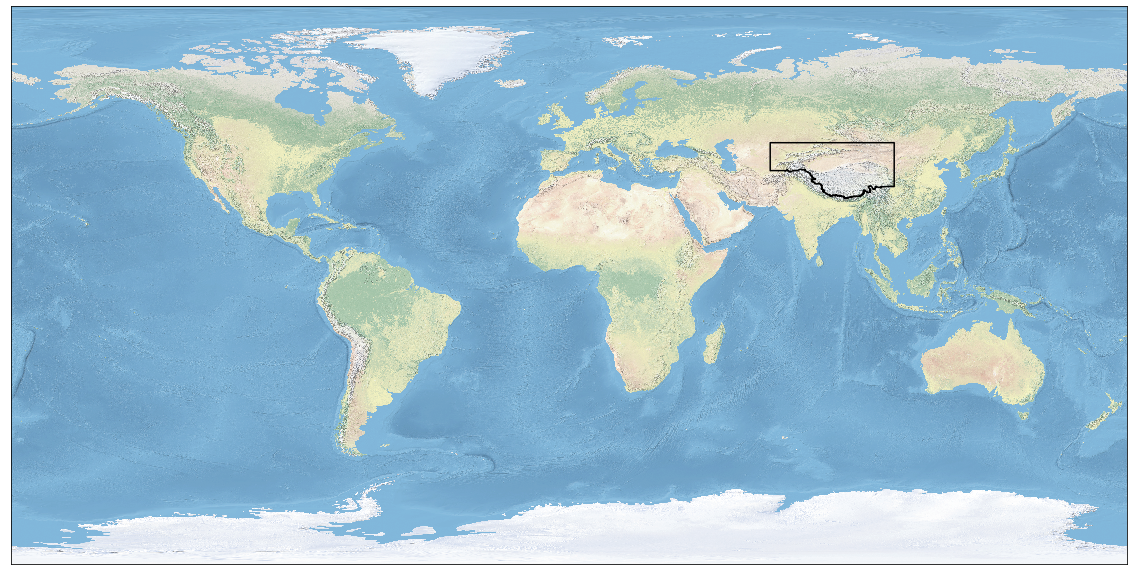

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx       miny   maxx  maxy
12  65.0  27.997963  105.0  46.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id     area  db_area  width  length  primeclass  \
0         13  G072126E38989N  737.675  737.229    0.0     0.0         0.0   
1         13  G079959E42153N    0.000  362.152    0.0     0.0         0.0   
2         13  G079990E41931N  358.247  358.247    0.0     0.0         0.0   
3         13  G079990E41931N  358.247  358.247    0.0     0.0         0.0   
4         13  G079990E41931N  358.247  358.247    0.0     0.0         0.0   
5         13  G079990E41931N  358.247  358.247    0.0     0.0         0.0   
6         13  G080334E42156N  282.721  282.720    0.0     0.0         0.0   
7         13  G080334E42156N  282.721  282.720    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date  \
0       0.0        0.0       0.0  2000-09-16T00:00:00   
1       0.0        0.0       0.0  2002-10-05T05:39:52   
2    2895.0        0.0    7021.0  2007-08-24T00:00:00   
3    2890.0     4459.0    7033.0  2007-08-24T00:00:00   
4    2895.0        0.0    7021.0  2007-08-24T00:00:00   
5    2890.0     4459.0    7033.0  2007-08-24T00:00:00   
6    2692.0        0.0    6709.0  2007-08-24T00:00:00   
7    2690.0     4478.0    6723.0  2007-08-24T00:00:00   

                          glac_name  \
0                              None   
1                              None   
2      CN5Y673P0037 Tuomuer Glacier   
3      CN5Y673P0037 Tuomuer Glacier   
4      CN5Y673P0037 Tuomuer Glacier   
5      CN5Y673P0037 Tuomuer Glacier   
6  CN5Y681B0016 Tugebieliqi Glacier   
7  CN5Y681B0016 Tugebieliqi Glacier   

                                            geometry  
0  POLYGON Z ((72.281582 38.835726 0, 72.28197 38...  
1  (POLYGON Z ((80.18603 42.20063 0, 80.1311 42.0...  
2  POLYGON Z ((79.85214999999999 41.985722 0, 79....  
3  POLYGON Z ((79.85214999999999 41.985722 0, 79....  
4  POLYGON Z ((79.85214999999999 41.985722 0, 79....  
5  POLYGON Z ((79.85214999999999 41.985722 0, 79....  
6  POLYGON Z ((80.253282 42.220657 0, 80.253502 4...  
7  POLYGON Z ((80.253282 42.220657 0, 80.253502 4...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 1 equals none


In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate     CenLon     CenLat  \
0  RGI60-13.54431  G072234E38780N  20000916  -9999999  72.233850  38.780240   
1  RGI60-13.05000  G080193E42063N  20020818  -9999999  80.193268  42.062546   
2  RGI60-13.43207  G079990E41931N  20070824  -9999999  79.990000  41.931000   
3  RGI60-13.43483  G080334E42156N  20070824  -9999999  80.334000  42.156000   
4  RGI60-13.53720  G080879E35302N  20101208  -9999999  80.879000  35.302000   

  O1Region O2Region     Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0       13        2  663.729  2908  ...      30  76460       0        0     0   
1       13        3  373.922  2901  ...     304  61445       0        0     0   
2       13        3  358.247  2895  ...     255  36410       0        0     0   
3       13        3  282.721  2692  ...      98  11703       0        0     0   
4       13        5  237.458  5353  ...     184  24140       0        0     1   

   TermType  Surging  Linkages                              Name  \
0         0        3         0           SU5X14308A001 Fedchenko   
1         0        9         9                              NONE   
2         0        9         9      CN5Y673P0037 Tuomuer Glacier   
3         0        9         9  CN5Y681B0016 Tugebieliqi Glacier   
4         0        9         9    CN5Z433D0008 Zhongfeng Glacier   

                                            geometry  
0  POLYGON ((72.30249556100006 38.84355663000008,...  
1  POLYGON ((80.20255235400003 42.22972116700004,...  
2  POLYGON ((79.85215045800004 41.98572162500005,...  
3  POLYGON ((80.31154765800005 42.25863608400005,...  
4  POLYGON ((80.73062117300003 35.31739218800004,...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

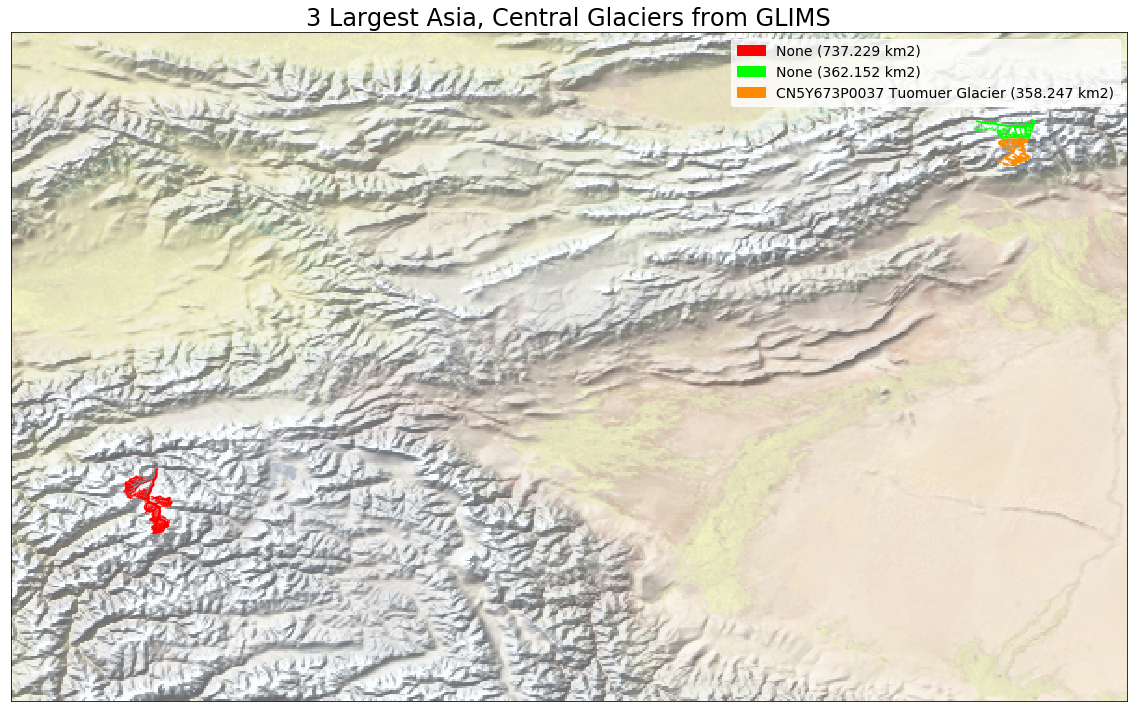

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][5] + ' (' + str(glims_glaciers_df['db_area'][5]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 71
maxx = 81
miny = 37
maxy = 43
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[5:6].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

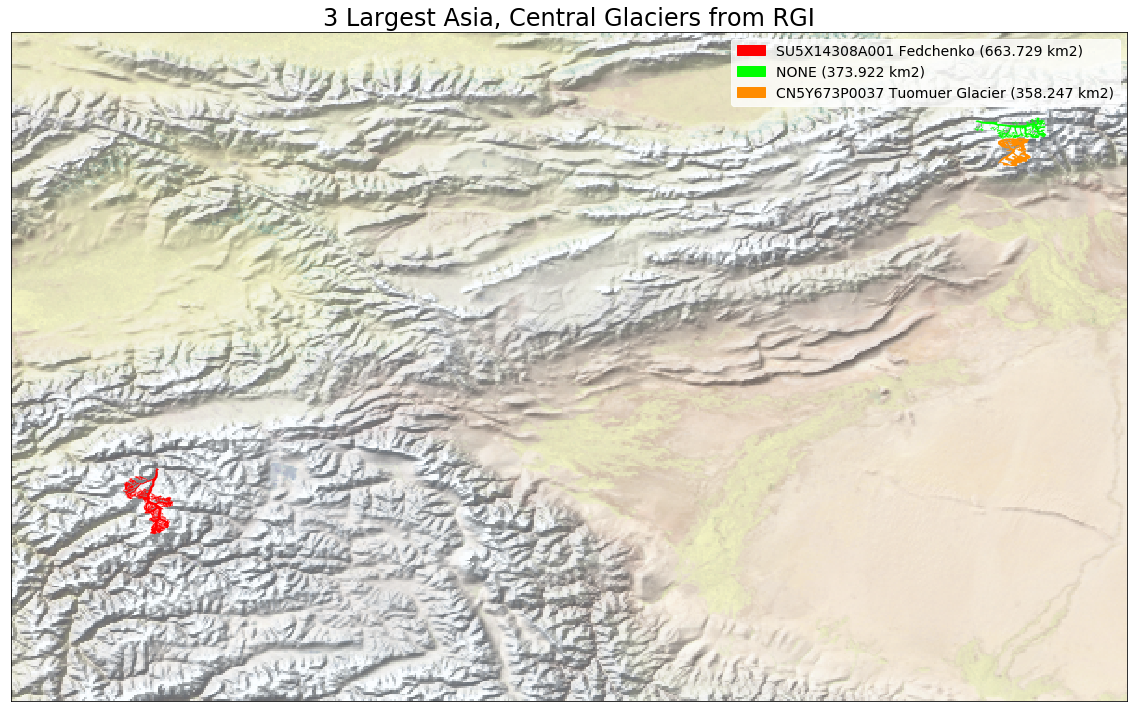

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 71
maxx = 81
miny = 37
maxy = 43
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

The top 3 glaciers for GLIMS and RGI do match they just don't have the same names or no names. Will enter the names manually. Here are the top 3 glaciers:

1. Fedchenko - in Tajikistan in the Pamir Mountain Range
2. South Inylchek - (accroding to Shangguan et al. (2015)) - in Kyrgystan in the Tian Shan Mountains
3. Tuomuer - in China in the Tian Shan Mountains

### Create final dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Only keep the first three rows (1st, 2nd, and 3rd largest)
final_data_df.drop([3, 4, 5, 6, 7], inplace = True)

# Add primary class (primeclass) column. 
final_data_df['primeclass'] = primeclass

# Add RGI ID column
final_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_data_df

region_no       reg_name                     glac_name        glims_id  \
0         13  Asia, Central                          None  G072126E38989N   
1         13  Asia, Central                          None  G079959E42153N   
2         13  Asia, Central  CN5Y673P0037 Tuomuer Glacier  G079990E41931N   

           rgi_id  primeclass  area_km2 area_src                 date  \
0  RGI60-13.54431           6   737.229     -999  2000-09-16T00:00:00   
1  RGI60-13.05000           5   362.152     -999  2002-10-05T05:39:52   
2  RGI60-13.43207           5   358.247     -999  2007-08-24T00:00:00   

                                            geometry  
0  POLYGON Z ((72.281582 38.835726 0, 72.28197 38...  
1  (POLYGON Z ((80.18603 42.20063 0, 80.1311 42.0...  
2  POLYGON Z ((79.85214999999999 41.985722 0, 79....

In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
# Clean up glacier names
final_data_df.iloc[0, final_data_df.columns.get_loc('glac_name')] = "Fedchenko Glacier"
final_data_df.iloc[1, final_data_df.columns.get_loc('glac_name')] = "South Inylchek Glacier"
final_data_df.iloc[2, final_data_df.columns.get_loc('glac_name')] = "Tuomuer Glacier"

glims date: 20000916
rgi date: 20000916
Averaging area: 700.479

glims date: 20021005
rgi date: 20020818
Averaging area: 368.03700000000003

glims date: 20070824
rgi date: 20070824
Averaging area: 358.247



In [19]:
final_data_df

region_no       reg_name               glac_name        glims_id  \
0         13  Asia, Central       Fedchenko Glacier  G072126E38989N   
1         13  Asia, Central  South Inylchek Glacier  G079959E42153N   
2         13  Asia, Central         Tuomuer Glacier  G079990E41931N   

           rgi_id  primeclass  area_km2 area_src        date  \
0  RGI60-13.54431           6   700.479        A  2000-09-16   
1  RGI60-13.05000           5   368.037        A  2002-10-05   
2  RGI60-13.43207           5   358.247        A  2007-08-24   

                                            geometry  
0  POLYGON Z ((72.281582 38.835726 0, 72.28197 38...  
1  (POLYGON Z ((80.18603 42.20063 0, 80.1311 42.0...  
2  POLYGON Z ((79.85214999999999 41.985722 0, 79....

### Plot final dataframe to check accuracy

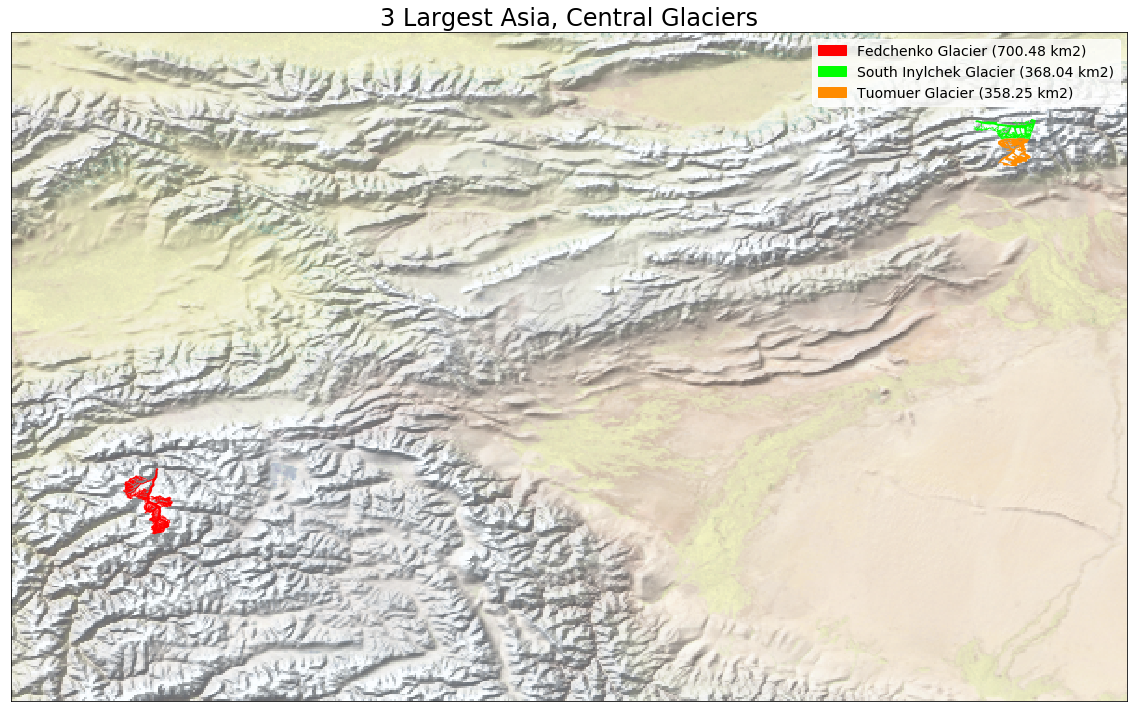

In [20]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(round(final_data_df['area_km2'][0], 2)) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(round(final_data_df['area_km2'][1], 2)) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(round(final_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 71
maxx = 81
miny = 37
maxy = 43
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='red')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [21]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

data/final-dataset/region-13-largest-glaciers.zip already extists


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [22]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_esri" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [23]:
ice_caps_ex_df

id         area                                           geometry
0  17068  2786.385699  POLYGON ((80.618455 35.567653, 80.618386 35.56...
1  34836  2743.613727  POLYGON ((80.052854 41.765997, 80.052544 41.76...
2     94  1742.628421  POLYGON ((72.356872 38.414861, 72.356892 38.41...
3  34561  1054.160808  POLYGON ((81.023376 42.124873, 81.022775 42.12...
4     12   628.776027  POLYGON ((94.740735 30.408859, 94.740789000000...
5  10688   603.900615  POLYGON ((91.216116 33.449129, 91.215765 33.44...
6  12869   591.759043  POLYGON ((87.467793 36.386334, 87.467817 36.38...
7  13018   591.150050  POLYGON ((79.302286 36.07406, 79.302469 36.074...
8  26320   524.785052  POLYGON ((73.146731 39.283975, 73.14668 39.283...
9  23763   519.561918  POLYGON ((75.458636 38.585118, 75.458713 38.58...

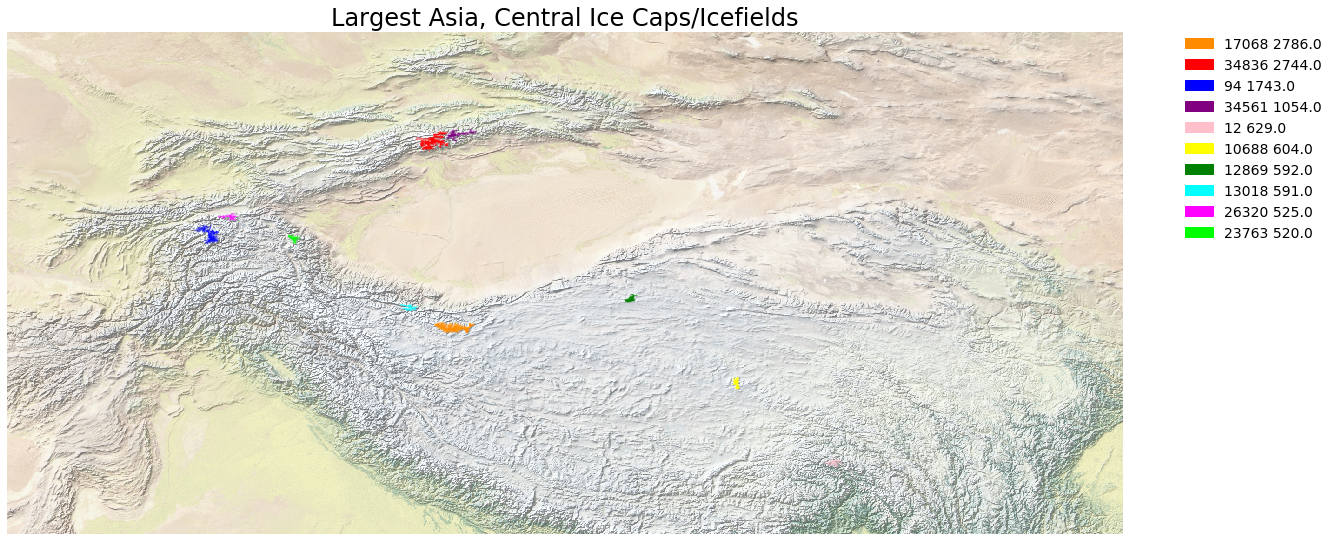

In [24]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = [str(ice_caps_ex_df['id'][0]) + ' ' + str(round(ice_caps_ex_df['area'][0])), 
                 str(ice_caps_ex_df['id'][1]) + ' ' + str(round(ice_caps_ex_df['area'][1])), 
                 str(ice_caps_ex_df['id'][2]) + ' ' + str(round(ice_caps_ex_df['area'][2])), 
                 str(ice_caps_ex_df['id'][3]) + ' ' + str(round(ice_caps_ex_df['area'][3])),
                 str(ice_caps_ex_df['id'][4]) + ' ' + str(round(ice_caps_ex_df['area'][4])),
                 str(ice_caps_ex_df['id'][5]) + ' ' + str(round(ice_caps_ex_df['area'][5])),
                 str(ice_caps_ex_df['id'][6]) + ' ' + str(round(ice_caps_ex_df['area'][6])),
                 str(ice_caps_ex_df['id'][7]) + ' ' + str(round(ice_caps_ex_df['area'][7])),
                 str(ice_caps_ex_df['id'][8]) + ' ' + str(round(ice_caps_ex_df['area'][8])),
                 str(ice_caps_ex_df['id'][9]) + ' ' + str(round(ice_caps_ex_df['area'][9]))]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [25]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Region ' + str(region_number) + ' 1st largest complex', 
                                      'Region ' + str(region_number) + ' 2nd largest complex',
                                      'Region ' + str(region_number) + '3rd largest complex',] 

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [26]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [27]:
# This section took about 1.5 hours to run so hard coding the info to variables and commenting out the code. 
# To rerun, uncomment the code
# Get glaciers in the 1st largest glacier complex
# ********** Uncomment out below to rerun ****************
#largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
#largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
#largest_ic_1_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
#largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
largest_ic_1_min_date = '2010-12-08' # Comment this out to rerun
largest_ic_1_max_date = '2011-08-05' # Comment this out to rerun
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
# ********** Uncomment out below to rerun ****************
#largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
#for i in range(len(largest_ic_1_glims_ids)):
#    if i == 0:
#        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
#    else:
#        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]
# ************ Uncomment out above to rerun ***************
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-1st-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_1_ids = ids[0]

# Get glaciers in the 2nd largest glacier complex
# ********** Uncomment out below to rerun ****************
#largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
#largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
#largest_ic_2_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
#largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
largest_ic_2_min_date = '2002-10-05' # Comment this out to rerun
largest_ic_2_max_date = '2007-08-24' # Comment this out to rerun
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
# ********** Uncomment out below to rerun ****************
#largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
#for i in range(len(largest_ic_2_glims_ids)):
#    if i == 0:
#        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
#    else:
#        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]
# ************ Uncomment out above to rerun ***************
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-2nd-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_2_ids = ids[0]

# Get glaciers in the 3rd largest glacier complex
# ********** Uncomment out below to rerun ****************
#largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
#largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
#largest_ic_3_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
#largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
# ************ Uncomment out above to rerun ***************
largest_ic_3_min_date = '2000-09-16'
largest_ic_3_max_date = '2003-08-08'
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
# ********** Uncomment out below to rerun ****************
#largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
#for i in range(len(largest_ic_3_glims_ids)):
#    if i == 0:
#        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
#    else:
#        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]
# ************ Uncomment out above to rerun ***************
# Read text file with the saved glims ids
# Comment out the 3 lines below to rerun
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-3rd-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_3_ids = ids[0]

1st largest start date: 2010-12-08
1st largest end date: 2011-08-05

2nd largest start date: 2002-10-05
2nd largest end date: 2007-08-24

3rd largest start date: 2000-09-16
3rd largest end date: 2003-08-08



In [28]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add the GLIMS IDS
final_catchment_data_df['glims_ids'] = [all_largest_ic_1_ids, all_largest_ic_2_ids, all_largest_ic_3_ids]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'glims_ids', 'geometry']]

# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [29]:
final_catchment_data_df

region_no       reg_name                        ic_name  primeclass  \
0        13  Asia, Central  Region 13 1st largest complex           2   
1        13  Asia, Central  Region 13 2nd largest complex           2   
2        13  Asia, Central   Region 133rd largest complex           2   

      area_km2    min_date    max_date  \
0  2786.385699  2010-12-08  2011-08-05   
1  2743.613727  2002-10-05  2007-08-24   
2  1742.628421  2000-09-16  2003-08-08   

                                           glims_ids  \
0  G080728E35377N, G080728E35377N, G081558E35412N...   
1  G080387E41918N, G080387E41918N, G080614E42104N...   
2  G072049E38971N, G072415E38745N, G072533E38755N...   

                                            geometry  
0  POLYGON ((80.618455 35.567653, 80.618386 35.56...  
1  POLYGON ((80.052854 41.765997, 80.052544 41.76...  
2  POLYGON ((72.356872 38.414861, 72.356892 38.41...

### Plot the final catchment dataframe to verify it looks correct

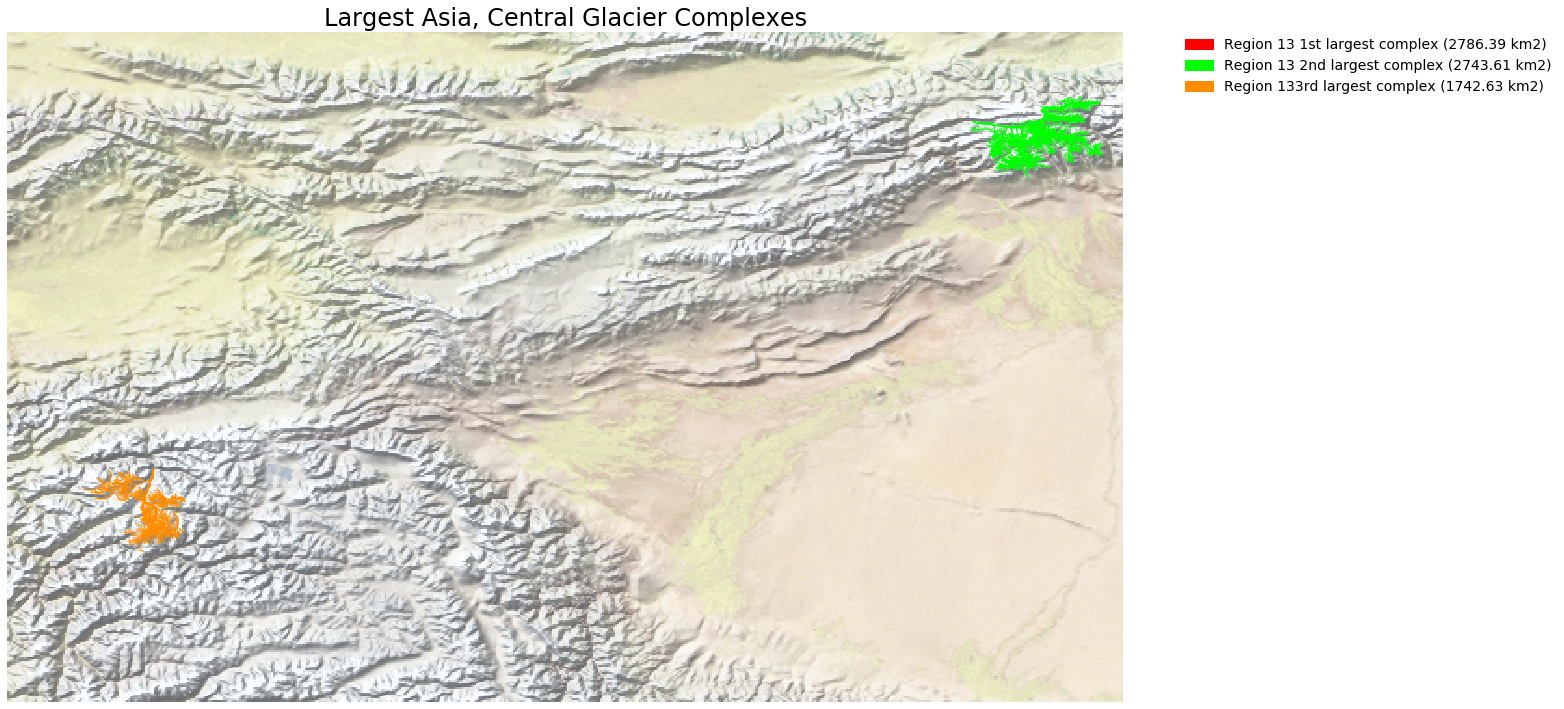

In [30]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 71
maxx = 81
miny = 37
maxy = 43
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [31]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

data/final-dataset/region-13-largest-complexes.zip already extists


In [32]:
# Save the glims ids to a text file because it took a couple of hours to run the id selection code
text_file_1st_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")

data/glims/processed/ice-caps/largest/region-13-1st-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/region-13-2nd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/region-13-3rd-largest-glims-ids.txt already extists
